***
Title     : `00-main.ipynb`<br>
Author    : Paul Covert<br>
Date      : 2025-02-15<br>
Version   : 1.0.0<br>
URL       : <br>
Aim       : Jupyter notebook for exploration of environmental data.  Use `00-main.py` for production calculations and visualization.
***

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import adcp
import tcm

In [2]:
# Define paths
DATA_RAW = Path("../data")

ALL_ADCP = adcp.paths.get("qc", root=DATA_RAW)
ALL_TCM = tcm.paths.get("qc", root=DATA_RAW)

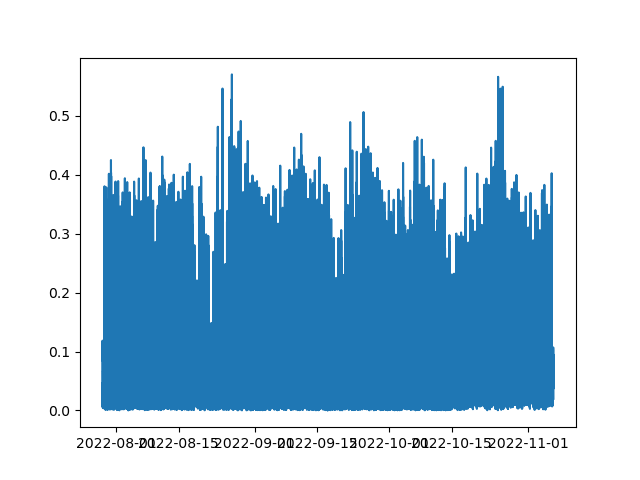

In [3]:
# Determine start and stop times of TCM traces 
# Site locations are: 
#  "anse_des_pilotes", "la_baleine"
#  "ile_aux_lievres_1", "ile_aux_lievres_2"

%matplotlib widget
fig, ax = plt.subplots(nrows=1, ncols=1)
df_tcm = tcm.read_csv(tcm.paths.get("la_baleine", root=DATA_RAW))
df_tcm = df_tcm.loc[tcm.consts.LA_BALEINE_SLICE]
ax.plot(df_tcm["speed"])

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(14,4))

for adcp_filepath, tcm_filepath in zip(ALL_ADCP, ALL_TCM):

    # Load adcp and tcm files
    ds_adcp = adcp.open_dataset(adcp_filepath)
    df_tcm = tcm.read_csv(tcm_filepath)

    # Trim tcm files

    # Estimate adcp altitude, assuming transduce is ~0.5m above bottom
    ds_adcp["xducer_altitude"] = (ds_adcp["xducer_depth"] + 0.5) - np.max(ds_adcp["depth"])

    # Select deepest adcp current measurement
    ds_adcp = ds_adcp.sel(depth=np.max(ds_adcp["depth"]))
    ds_adcp = ds_adcp.dropna("time")
    df_adcp = ds_adcp.to_pandas()

    # Interpolate tcm speed and direction onto adcp timeseries
    # Note: tcm measures current once per minute, while adcp current is once
    #       every 5 minutes
    df_adcp["speed_tcm"] = np.interp(df_adcp.index, df_tcm.index, df_tcm["speed"])
    df_adcp["dir_tcm"] = np.interp(df_adcp.index, df_tcm.index, df_tcm["dir"])

    

    